In [43]:
import pandas as pd
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.genmod.families import NegativeBinomial
from statsmodels.genmod.families import Poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import re

## Import des données

De https://dutangc.perso.math.cnrs.fr/RRepository/ (Export via R, puis création de CSV logé sur le sharepoint)

In [44]:
url = "https://genes-my.sharepoint.com/:x:/g/personal/rchaperon_ensae_fr/IQCuvdcp-twpRpc0xtLWmTvBAX4S7Yuk_pfuEUXGT0VjG0I?download=1"
response = requests.get(url)
response.raise_for_status()


freMTPLfreq = pd.read_csv(io.StringIO(response.text))
freMTPLfreq.head()

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60


In [45]:
url = "https://genes-my.sharepoint.com/:x:/g/personal/rchaperon_ensae_fr/IQCnNZUkH1BcTb8mn_9yjvP8AZX5pYH5lgYxxpeB5pwonsM?download=1"
response = requests.get(url)
response.raise_for_status()

freMTPLsev = pd.read_csv(io.StringIO(response.text))
freMTPLsev.head()


,PolicyID,ClaimAmount
0,63987,1172
1,310037,1905
2,314463,1150
3,318713,1220
4,309380,55077


In [46]:
merged_df = pd.merge(
    freMTPLfreq,
    freMTPLsev,
    on='PolicyID',
    how='left'
)

merged_df.fillna(0, inplace=True)
merged_df.head()

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,0.0


In [47]:
merged_df.columns

Index(['PolicyID', 'ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge',
       'Brand', 'Gas', 'Region', 'Density', 'ClaimAmount'],
      dtype='object')

## I. Modélisation de la fréquence des sinistres

## I.1. Préparation et compréhension des données

Avant d’estimer un modèle de fréquence (GLM – Poisson, Binomiale Négative), il est essentiel de comprendre la structure du jeu de données et d’identifier d’éventuels traitements à appliquer.

### I.1.1. Vérification de la qualité et distribution des variables

Nous commençons par examiner :
- les valeurs manquantes,
- les types (numériques / catégorielles),
- les distributions,
- la présence de valeurs aberrantes.

L’extension *VSCode Data Wrangler* permet d’obtenir rapidement un aperçu global : nombre de lignes, cardinalités des colonnes, min/max, histogrammes, etc.

Cela nous permet d’identifier :
- les variables numériques continues (CarAge, DriverAge, Density, Exposure),
- les variables catégorielles (Brand, Gas, Region, Power),
- l’absence d’anomalies majeures dans les colonnes.

### I.1.2. Vérification des variables catégorielles

Pour les variables catégorielles, on vérifie :
- le nombre de modalités,
- la proportion de chaque modalité,
- la présence de classes très rares qu’il faudrait regrouper.

Toutes les catégories ont des effectifs suffisants pour être modélisées directement via `C(variable)` dans un GLM.

### I.1.3. Compréhension et utilisation d’Exposure

Dans les modèles de fréquence, le nombre de sinistres observé sur une période dépend mécaniquement :
- de l’intensité de sinistre λ,
- de la durée d’exposition à ce risque.

L’Exposure représente cette durée relative (par exemple :
- 1 = une année entière,
- 0.5 = demi-année,
- éventuellement >1 si le relevé dépasse la période standard).

Dans un GLM de Poisson, l’exposition est intégrée via un *offset* :
$$
\log(\mathbb{E}[Y_i]) = X_i^\top \beta + \log(\text{Exposure}_i)
$$

Ce qui revient à modéliser :

$$
\mathbb{E}[Y_i] = \text{Exposure}_i \cdot \exp(X_i^\top \beta)
$$


L’offset est donc :
- ajouté **à droite** du modèle,
- **fixé** (pas de paramètre estimé),
- utilisé pour obtenir une fréquence annualisée.

             PolicyID        ClaimNb       Exposure   Power         CarAge  \
count   413169.000000  413169.000000  413169.000000  413169  413169.000000   
unique            NaN            NaN            NaN      12            NaN   
top               NaN            NaN            NaN       f            NaN   
freq              NaN            NaN            NaN   95718            NaN   
mean    206585.000000       0.039163       0.561088     NaN       7.532404   
std     119271.761023       0.204053       0.369477     NaN       5.763011   
min          1.000000       0.000000       0.002732     NaN       0.000000   
25%     103293.000000       0.000000       0.200000     NaN       3.000000   
50%     206585.000000       0.000000       0.540000     NaN       7.000000   
75%     309877.000000       0.000000       1.000000     NaN      12.000000   
max     413169.000000       4.000000       1.990000     NaN     100.000000   

            DriverAge                       Brand      Gas  Reg

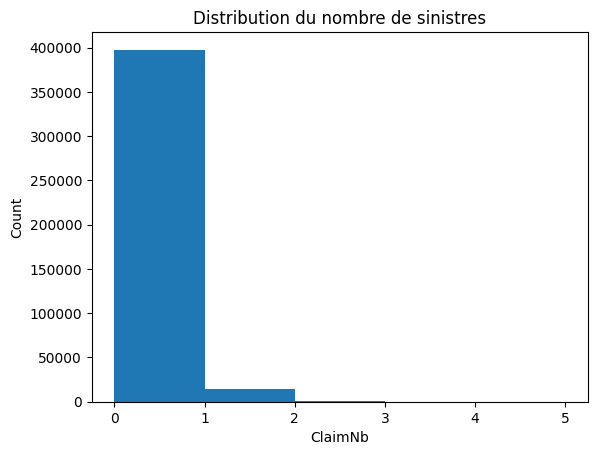

/tmp/ipykernel_38314/4014210851.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby('DriverAge_bin').agg(


               n_policies  mean_claims      rate
DriverAge_bin                                   
(17, 25]            25863     0.061207  0.141744
(25, 35]            92314     0.035238  0.072288
(35, 45]           102441     0.036811  0.067100
(45, 55]            98552     0.040811  0.069308
(55, 65]            52175     0.036454  0.059830
(65, 99]            41824     0.039451  0.055677


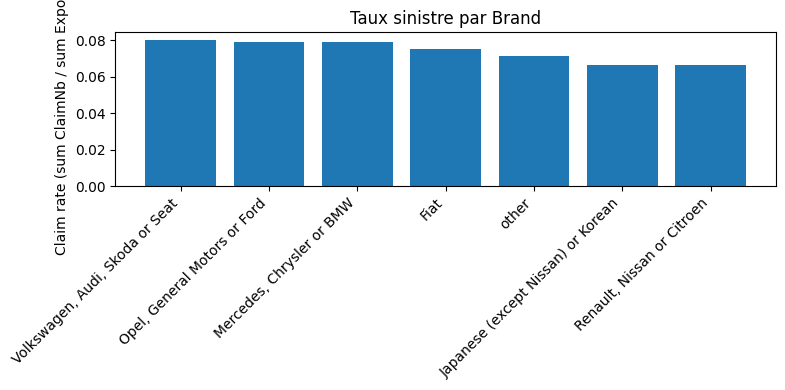

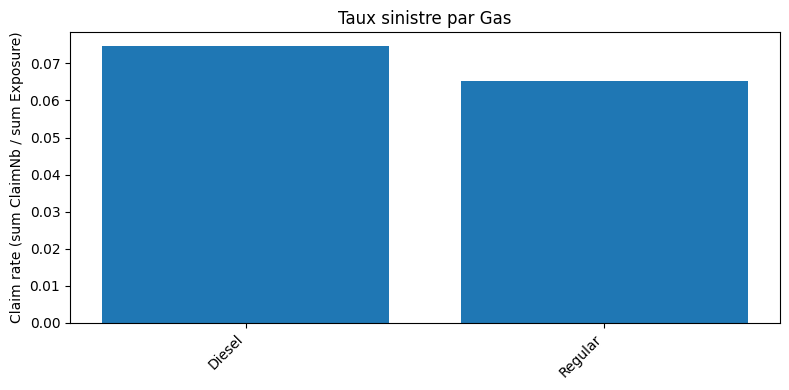

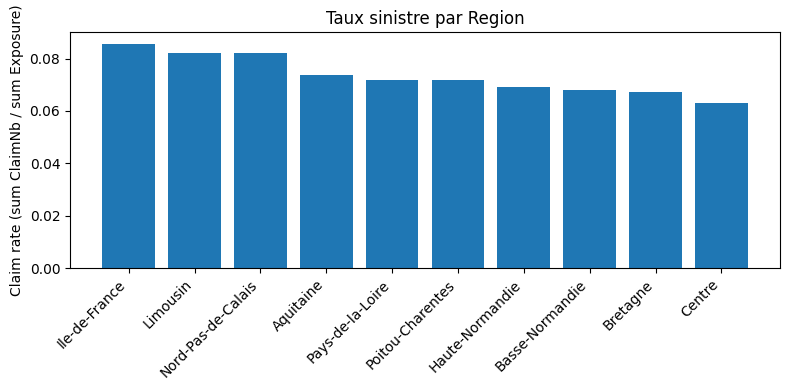

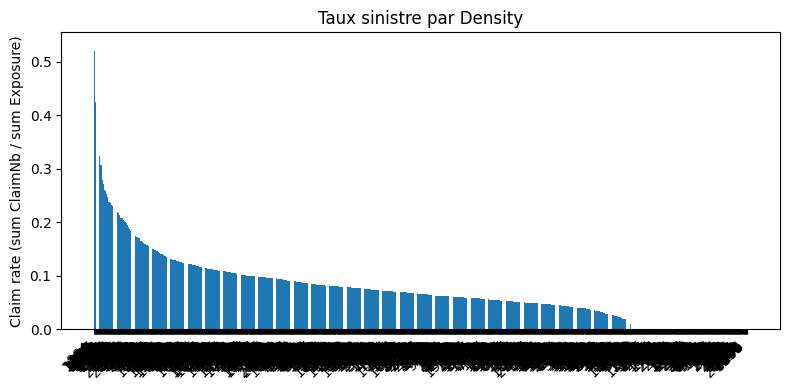

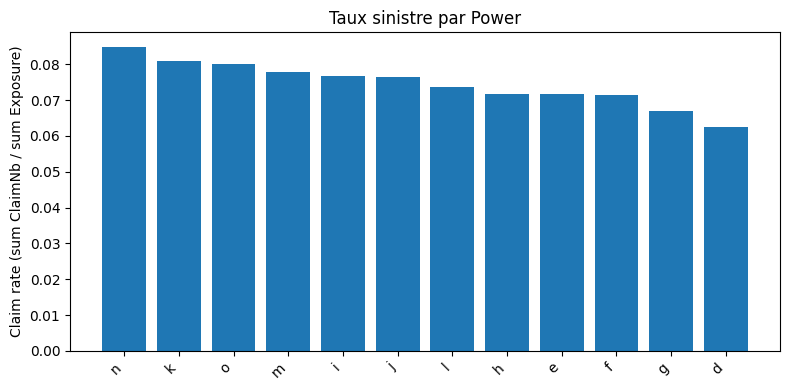

             CarAge  DriverAge  Exposure   ClaimNb
CarAge     1.000000  -0.046414  0.140104  0.004506
DriverAge -0.046414   1.000000  0.194260 -0.006128
Exposure   0.140104   0.194260  1.000000  0.076039
ClaimNb    0.004506  -0.006128  0.076039  1.000000


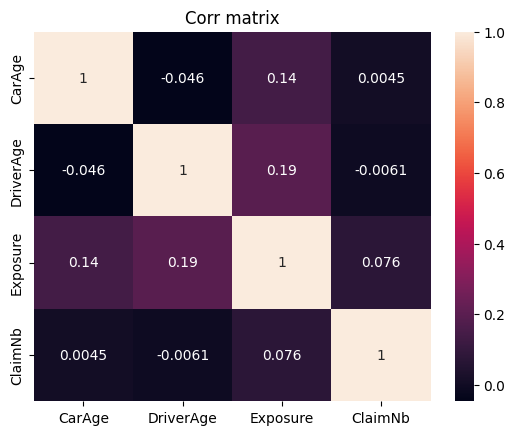

In [48]:
df = freMTPLfreq .copy()

# Statistiques globales
print(df.describe(include='all'))
print("\nTaux moyen sinistres (ClaimNb / Exposure):", (df['ClaimNb']/df['Exposure']).mean())

# Colonnes catégorielles / numériques
cat_cols = ['Brand','Gas','Region','Density', 'Power']
num_cols = ['CarAge','DriverAge','Exposure']

# Distribution du nombre de sinistres
plt.figure()
plt.hist(df['ClaimNb'], bins=range(int(df['ClaimNb'].max())+2))
plt.xlabel('ClaimNb'); plt.ylabel('Count'); plt.title('Distribution du nombre de sinistres')
plt.show()

# Taux de sinistre par bucket 
df['DriverAge_bin'] = pd.cut(df['DriverAge'], bins=[17,25,35,45,55,65,99])
summary = df.groupby('DriverAge_bin').agg(
    n_policies=('PolicyID','count'),
    mean_claims=('ClaimNb','mean'),
    rate=('ClaimNb', lambda x: x.sum()/df.loc[x.index,'Exposure'].sum())
)
print(summary)

# Bar plots pour variables catégorielles: taux sinistres (somme ClaimNb / somme Exposure)
for c in cat_cols:
    grp = df.groupby(c).agg(total_claims=('ClaimNb','sum'), total_exposure=('Exposure','sum'))
    grp['rate'] = grp['total_claims'] / grp['total_exposure']
    grp = grp.sort_values('rate', ascending=False)
    plt.figure(figsize=(8,4))
    plt.bar(grp.index.astype(str), grp['rate'])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Taux sinistre par {c}')
    plt.ylabel('Claim rate (sum ClaimNb / sum Exposure)')
    plt.tight_layout()
    plt.show()

# Corrélations pour variables numériques (sur la fréquence de sinistres par exposure)
num = df[num_cols + ['ClaimNb']]
corr = num.corr()
print(corr)
sns.heatmap(corr, annot=True); plt.title('Corr matrix'); plt.show()

# I.2 : Modélisation GLM du nombre de sinistres

Dans cette partie, nous allons construire des modèles **linéaires généralisés (GLM)** pour expliquer et prédire le nombre de sinistres (`ClaimNb`) par contrat. L'objectif est de comprendre l'impact des différentes variables explicatives et de sélectionner un modèle robuste et performant.

### Démarche :

1. **Modèle de référence Poisson**  
   - Nous commençons par un GLM **Poisson**, adapté aux variables discrètes représentant un nombre d'événements.  
   - Nous incluons toutes les variables explicatives pertinentes (`CarAge`, `DriverAge`, `Brand`, `Gas`, `Region`, `Density`, `Power`), avec un **offset** égal au logarithme de l'`Exposure` pour tenir compte de la durée du contrat.

2. **Sélection des variables explicatives**  
   - Nous examinerons les coefficients et leur significativité statistique pour identifier les variables les moins utiles.  
   - Nous testerons différentes combinaisons de variables pour observer l'impact sur les performances du modèle.

3. **Tests d'autres modèles**  
   - En cas de surdispersion, nous comparerons le Poisson à des GLM **Negative Binomial**, qui permettent de mieux gérer la variance plus élevée que la moyenne.

4. **Évaluation et comparaison**  
   - Les modèles seront comparés à l'aide de l'**AIC** sur le jeu d'entraînement pour évaluer le compromis complexité / qualité de fit.  
   - Nous utiliserons également un **jeu de validation** (1/4 des données) pour mesurer la performance prédictive réelle.

Cette approche nous permettra de sélectionner un modèle final qui équilibre **interprétabilité**, **bonne adéquation aux données** et **capacité de généralisation** sur de nouvelles observations.


In [49]:
# colonnes explicatives candidates
X_cols = ['Power','CarAge','DriverAge','Brand','Gas','Region','Density']
y_col = 'ClaimNb'
offset_col = 'Exposure'

policy_ids = df['PolicyID'].unique()

train_ids, test_ids = train_test_split(
    policy_ids,
    test_size=0.25,
    random_state=42
)

train = df[df['PolicyID'].isin(train_ids)].copy()
test = df[df['PolicyID'].isin(test_ids)].copy()

print("Train / Test sizes:", train.shape, test.shape)

Train / Test sizes: (309876, 11) (103293, 11)


In [50]:
# formule initiale
formula = "ClaimNb ~ CarAge + DriverAge + C(Brand) + C(Gas) + C(Region) + Density + C(Power)"

# fit Poisson with offset = log(Exposure)
train = train.copy()
train['log_exposure'] = np.log(train['Exposure'])
test['log_exposure'] = np.log(test['Exposure'])


poisson = smf.glm(formula=formula, data=train, 
                  family=sm.families.Poisson(), 
                  offset=train['log_exposure']).fit()
print(poisson.summary())

# Overdispersion check (Pearson chi2 / df_resid)
pearson_chi2 = sum(poisson.resid_pearson**2)
dispersion = pearson_chi2 / (poisson.df_resid - 1)
print("Dispersion (Pearson chi2 / df):", dispersion)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               309876
Model:                            GLM   Df Residuals:                   309845
Model Family:                 Poisson   Df Model:                           30
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50697.
Date:                Thu, 11 Dec 2025   Deviance:                       78067.
Time:                        22:12:00   Pearson chi2:                 5.37e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002234
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [51]:
coefs = poisson.summary2().tables[1]
non_sig_levels = coefs[coefs['P>|z|'] > 0.05].index.tolist()
print("Niveaux non significatifs :", non_sig_levels)

Niveaux non significatifs : ['C(Brand)[T.Mercedes, Chrysler or BMW]', 'C(Brand)[T.Opel, General Motors or Ford]', 'C(Brand)[T.Volkswagen, Audi, Skoda or Seat]', 'C(Brand)[T.other]', 'C(Region)[T.Basse-Normandie]', 'C(Region)[T.Bretagne]', 'C(Region)[T.Haute-Normandie]', 'C(Region)[T.Ile-de-France]', 'C(Region)[T.Nord-Pas-de-Calais]', 'C(Region)[T.Pays-de-la-Loire]', 'C(Region)[T.Poitou-Charentes]', 'C(Power)[T.g]', 'C(Power)[T.l]', 'C(Power)[T.m]', 'C(Power)[T.n]', 'C(Power)[T.o]']


### Diagnostic de la Sur-dispersion

L'hypothèse fondamentale de la loi de Poisson est l'équidispersion, c'est-à-dire l'égalité entre l'espérance et la variance : $E(Y) = Var(Y)$.

Or, notre calcul de la dispersion indique :
$$ \hat{\phi} \approx 1.73 $$

Une valeur de **1.73** met en évidence une **sur-dispersion significative** (variance supérieure à la moyenne). Bien qu'il soit possible de réaliser un test asymptotique formel pour vérifier si cet écart à 1 est statistiquement significatif, l'ampleur de la valeur observée nous permet de rejeter l'hypothèse de dispersion unitaire ($\phi=1$) sans ambiguïté.

**Conséquence sur l'inférence :**
L'utilisation d'un modèle de Poisson standard sur ces données conduit à **sous-estimer la variance réelle** des estimateurs. En conséquence, les erreurs-types (*standard errors*) sont artificiellement réduites, gonflant les statistiques de test (*t-values*) et rendant les **p-valeurs faussement significatives** (trop faibles). Nous ne pouvons donc pas nous fier à ce premier modèle pour la sélection des variables.

### Correction : Modèle Quasi-Poisson

Pour pallier ce problème et sélectionner rigoureusement les variables, nous optons pour une approche **Quasi-Poisson**.
Ce modèle relâche la contrainte de variance en posant $Var(Y) = \phi E(Y)$, où $\phi$ est estimé librement à partir des données.

**Impact méthodologique :**
* Les coefficients $\hat{\beta}$ resteront identiques à ceux du modèle Poisson.
* La matrice de covariance sera multipliée par $\hat{\phi} \approx 1.73$.
* Les erreurs-types seront corrigées (augmentées), ce qui produira des **p-valeurs ajustées et fiables**.

Nous utiliserons ces nouvelles métriques pour valider la significativité de nos variables explicatives.

In [52]:
model = smf.glm(formula=formula, data=train, 
                family=sm.families.Poisson(), 
                offset=train['log_exposure'])

quasi_poisson_results = model.fit(scale="X2")

print(quasi_poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               309876
Model:                            GLM   Df Residuals:                   309845
Model Family:                 Poisson   Df Model:                           30
Link Function:                    Log   Scale:                          1.7324
Method:                          IRLS   Log-Likelihood:                -29265.
Date:                Thu, 11 Dec 2025   Deviance:                       78067.
Time:                        22:12:19   Pearson chi2:                 5.37e+05
No. Iterations:                     9   Pseudo R-squ. (CS):           0.001290
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [53]:
coefs = quasi_poisson_results.summary2().tables[1]
non_sig_levels = coefs[coefs['P>|z|'] > 0.05].index.tolist()
print("Niveaux non significatifs :", non_sig_levels)

Niveaux non significatifs : ['C(Brand)[T.Mercedes, Chrysler or BMW]', 'C(Brand)[T.Opel, General Motors or Ford]', 'C(Brand)[T.Renault, Nissan or Citroen]', 'C(Brand)[T.Volkswagen, Audi, Skoda or Seat]', 'C(Brand)[T.other]', 'C(Region)[T.Basse-Normandie]', 'C(Region)[T.Bretagne]', 'C(Region)[T.Haute-Normandie]', 'C(Region)[T.Ile-de-France]', 'C(Region)[T.Limousin]', 'C(Region)[T.Nord-Pas-de-Calais]', 'C(Region)[T.Pays-de-la-Loire]', 'C(Region)[T.Poitou-Charentes]', 'C(Power)[T.g]', 'C(Power)[T.h]', 'C(Power)[T.l]', 'C(Power)[T.m]', 'C(Power)[T.n]', 'C(Power)[T.o]']


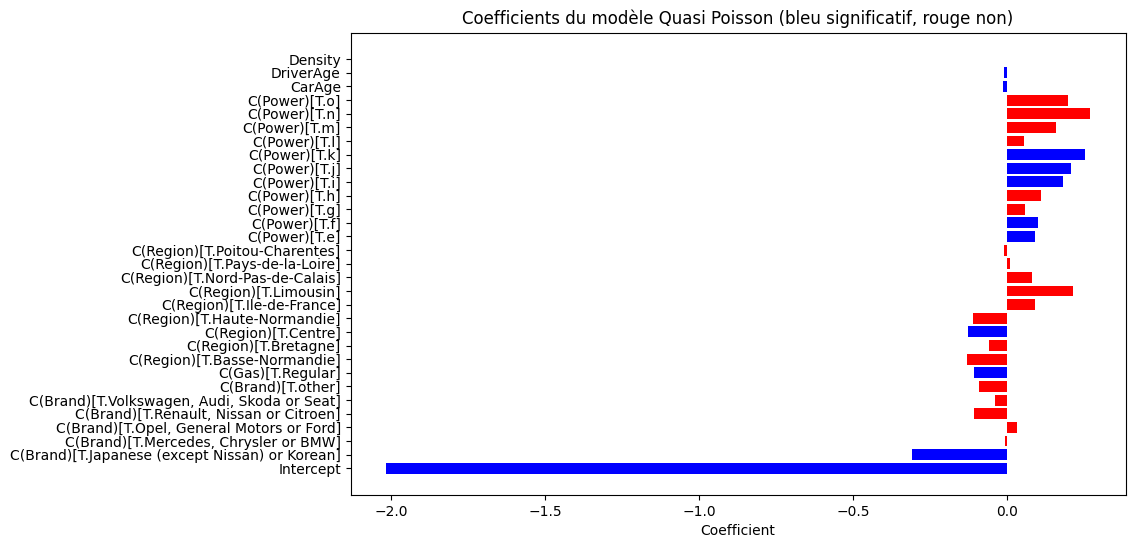

In [54]:
coefs_plot = coefs.copy()
coefs_plot['significant'] = coefs_plot['P>|z|'] < 0.05
plt.figure(figsize=(10,6))
plt.barh(coefs_plot.index, coefs_plot['Coef.'], color=coefs_plot['significant'].map({True:'blue', False:'red'}))
plt.xlabel('Coefficient')
plt.title('Coefficients du modèle Quasi Poisson (bleu significatif, rouge non)')
plt.show()

In [55]:
non_significant_brands = [
    'Mercedes, Chrysler or BMW', 
    'Opel, General Motors or Ford',
    'Renault, Nissan or Citroen', 
    'Volkswagen, Audi, Skoda or Seat', 
    'other',
    'Fiat'
]

non_significant_regions = [
    'Basse-Normandie', 
    'Haute-Normandie', 
    'Ile-de-France', 
    'Limousin', 
    'Nord-Pas-de-Calais', 
    'Pays-de-la-Loire', 
    'Poitou-Charentes',
    'Aquitaine'
]

non_significant_power = ['g', 'm', 'o', 't', 'f', 'e', 'h', 'k', 'l', 'j', 'i', 'n']
 


def apply_aggregation(df):
    """Applique les règles de regroupement définies ci-dessus au DataFrame."""
    
    # Brand Aggregation
    df['Brand_Agg'] = np.where(
        df['Brand'].isin(non_significant_brands),
        'Ref_Brand', 
        df['Brand']
    )

    # Region Aggregation
    df['Region_Agg'] = np.where(
        df['Region'].isin(non_significant_regions),
        'Ref_Region', 
        df['Region']
    )
    
    # Power Aggregation
    df['Power_Agg'] = np.where(
        df['Power'].isin(non_significant_power),
        'Ref_Power', 
        df['Power']
    )
    return df

train = apply_aggregation(train.copy())
test = apply_aggregation(test.copy()) 

Dans ce modèle, les catégories manquantes dans les résultats de la régression (comme Diesel, les marques Japonaises, la Bretagne et le groupe Ref_Power agrégé) sont la Baseline (la référence) et leur effet est absorbé dans la constante.

Variables Continues :

Les trois variables continues conservées présentent toutes un effet hautement significatif sur la fréquence. L'âge du conducteur et l'âge de la voiture ont tous deux un impact négatif sur la fréquence (plus ils sont vieux, plus la fréquence diminue). Inversement, la densité de population a un effet positif sur la fréquence, confirmant un risque plus élevé en zone urbaine.

Variables Catégorielles Agrégées :

Marque (C(Brand_Agg)) : Après agrégation, le grand groupe T.Ref_Brand (qui contient l'ensemble des marques non significatives) présente un risque significativement plus élevé que la Baseline, les marques Japonaises.

Carburant (C(Gas)) : L'effet du T.Regular (Essence) est significativement plus faible que celui de la Baseline, le Diesel.

Région (C(Region_Agg)) : Le groupe agrégé T.Ref_Region (toutes les régions non significatives) présente un risque significativement plus élevé que la Baseline, la Bretagne.

Puissance (C(Power_Agg)) : Le niveau T.d est l'unique niveau de puissance conservé et présente un risque significativement plus faible que la Baseline, le groupe Ref_Power agrégé.

In [56]:
new_formula = "ClaimNb ~ CarAge + DriverAge + C(Brand_Agg) + C(Gas) + C(Region_Agg) + Density + C(Power_Agg)"

model_agg = smf.glm(formula=new_formula, data=train, 
                    family=sm.families.Poisson(), 
                    offset=train['log_exposure']).fit(scale="X2")

print(model_agg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               309876
Model:                            GLM   Df Residuals:                   309867
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.7314
Method:                          IRLS   Log-Likelihood:                -29304.
Date:                Thu, 11 Dec 2025   Deviance:                       78145.
Time:                        22:12:41   Pearson chi2:                 5.36e+05
No. Iterations:                     9   Pseudo R-squ. (CS):           0.001145
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Nous venons d'utiliser une loi de quasi poissson pour faire de la sélection de variable. Ce modèle s'y prête bien, néanmoins pour comparer plusieurs modèles avec une métrique telle que l'AIC, ceci n'est pas possible avec une loi quasi poisson, qui n'a pas de fonction de vraisemblance. Nous allons donc comparer un modèle de Poisson, et un modèle de loi Binomiale Négative, basés sur la sélection de variables effectuée précedemment, pour déterminer quel modèle est le plus performant.
Deux métriques seront utilisés : 
- L'AIC
- La performance sur le jeu de test, via MAE

In [57]:
# Formule finale avec les variables agrégées (simplifiées)
final_formula = "ClaimNb ~ CarAge + DriverAge + C(Brand_Agg) + C(Gas) + C(Region_Agg) + Density + C(Power_Agg)"

# Modèle Poisson 
poisson_model = smf.glm(
    formula=final_formula,
    data=train,
    family=Poisson(),
    offset=train['log_exposure']
).fit()

# Modèle Binomial Négatif 
nb_model = smf.glm(
    formula=final_formula,
    data=train,
    family=NegativeBinomial(alpha=0.1), # alpha est le paramètre de surdispersion
    offset=train['log_exposure']
).fit()

def weighted_mae(df, actual_claim_col, exposure_col, rate_col):
    """
    Calcule l'Erreur Absolue Moyenne (MAE) pondérée par l'exposition.
    MAE = (Somme de [Exposure * |Taux Réel - Taux Prédit|]) / (Somme de Exposure)
    """
    
    # Taux Réel = ClaimNb / Exposure
    actual_rate = df[actual_claim_col] / df[exposure_col]
    
    # Calcul de l'erreur absolue pondérée
    total_error = np.sum(df[exposure_col] * np.abs(actual_rate - df[rate_col]))
    
    # Division par l'exposition totale pour obtenir le MAE pondéré
    total_exposure = np.sum(df[exposure_col])
    return total_error / total_exposure


# Prédictions de Taux de Fréquence (lambda hat) sur le jeu de TEST
test['poisson_rate'] = poisson_model.predict(test)
test['nb_rate'] = nb_model.predict(test)
test['quasi_poisson_rate'] = model_agg.predict(test)

# 1. Comparaison AIC (Ajustement sur Train)
print("1. CRITÈRE D'INFORMATION D'AKAIKE (AIC) :")
print(f"   AIC Poisson : {poisson_model.aic:.4f}")
print(f"   AIC Binomial Négatif : {nb_model.aic:.4f}")

# 2. Comparaison MAE sur Test (Performance sur Test)
mae_poisson = weighted_mae(test, 'ClaimNb', 'Exposure', 'poisson_rate')
mae_nb = weighted_mae(test, 'ClaimNb', 'Exposure', 'nb_rate')

print("\n2. ERREUR ABSOLUE MOYENNE PONDÉRÉE :")
print(f"   MAE Poisson sur Test : {mae_poisson:.6f}")
print(f"   MAE Binomial Négatif sur Test : {mae_nb:.6f}")

1. CRITÈRE D'INFORMATION D'AKAIKE (AIC) :
   AIC Poisson : 101491.2028
   AIC Binomial Négatif : 101429.2191

2. ERREUR ABSOLUE MOYENNE PONDÉRÉE :
   MAE Poisson sur Test : 0.133483
   MAE Binomial Négatif sur Test : 0.133521


Ces résultats permettent de conclure sur l'utilisation du modèle. On choisira un modèle de Poisson pour la modélisation de la fréquence, puisqu'une loi Binomiale Négative n'apporte pas de gain significatif en AIC, et présente une performance sur le jeu de test légèrement moins bonne qu'un modèle Poisson. On décide donc de valoriser la simplicité et l'interprétabilité, le modèle de Poisson étant plus simple qu'une Binomiale Négative.

## II. Modélisation du coût des sinistres

In [58]:
df2 = merged_df.copy()
df2=df2[df2['ClaimAmount'] > 0]

## II.1 Analyse descriptive de la sévérité
II.1.a Analyse globale

In [59]:
df2['ClaimAmount'].describe(percentiles=[0.05, 0.95])

count    1.618100e+04
mean     2.129972e+03
std      2.106364e+04
min      2.000000e+00
5%       8.100000e+01
50%      1.156000e+03
95%      4.284000e+03
max      2.036833e+06
Name: ClaimAmount, dtype: float64

La distribution centré autour de 1156€ est très fortement étalé sur la droite, expliquant l'écart type particulièrement élevée (10x supérieur à la moyenne). On observe un écart important entre le qauntile 95% (à 4284€) et le sinistre maximum à 2M€. Nous affichons la dernière valeurs pour avoir des informations sur la queue de distribution.

In [60]:
df2['ClaimAmount'].nlargest(10)

101305    2036833.0
35396     1402330.0
100059     306559.0
52377      301302.0
269453     281403.0
92543      254944.0
198436     240884.0
353642     210837.0
254551     209462.0
152467     205090.0
Name: ClaimAmount, dtype: float64

In [61]:
df2['ClaimAmount'].nlargest(1)/df2['ClaimAmount'].sum()

101305    0.059098
Name: ClaimAmount, dtype: float64

Le coût du sinistre le plus sévère dépasse, à lui seul, 5% de la charge totale des sinistres du portefeuille. L'ajout du deuxième sinistre le plus sévère porte cette proportion à près de 10%.

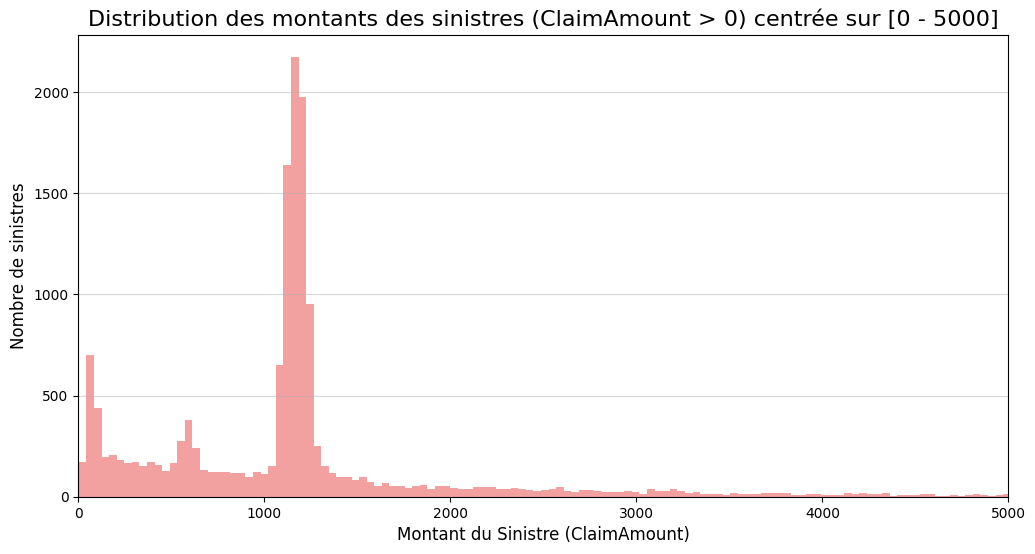

In [62]:
plt.figure(figsize=(12, 6))

sns.histplot(
    df2['ClaimAmount'],
    bins=50000,           
    kde=False,
    color='lightcoral',
    edgecolor='black'
)

plt.xlim(0, 5000)

plt.title("Distribution des montants des sinistres (ClaimAmount > 0) centrée sur [0 - 5000]", fontsize=16)
plt.xlabel("Montant du Sinistre (ClaimAmount)", fontsize=12)
plt.ylabel("Nombre de sinistres", fontsize=12)   
plt.grid(axis='y', alpha=0.5)

plt.show()


L'histogramme avec une granularité réduite laisse fait apparaitre une distribution multimodale avec plusieurs pics distincts. Le pic notable situé aux alentours de 1100 € - 1300€ semble correspondre après recherche au montant forfaitaire de recours inter-compagnies (convention IRSA), il ne s'agirait donc pas du coût réel du sinistre

II.1.b Analyse par variable


Nous supposons que les variables explicatives 'Brand' et 'Power' peuvent traduire un même effet, celui d'avoir une voiture d'entrée, de milieu ou de haut de gamme. Nous supposons que les variables explicatives 'Brand' et 'Power' peuvent traduire un même effet, celui d'avoir une voiture d'entrée, de milieu ou de haut de gamme. Dans l'analyse qui suit, nous excluons dans un premier temps les sinsitres au dela du 99ème centile. Nous faisons ainsi l'hypothèse qu'ils ne peuvent pas être prédit à partir des variables explicatives.

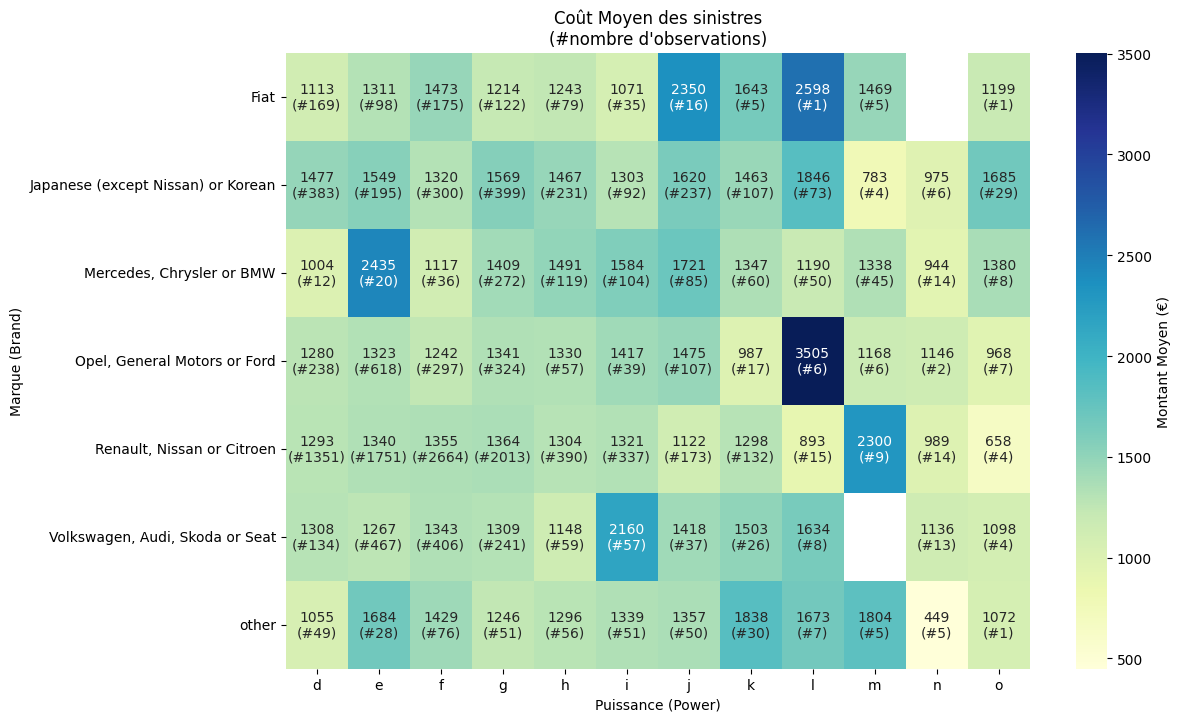

In [63]:
df_clean = df2[df2['ClaimAmount'] < df2['ClaimAmount'].quantile(0.99)].copy()


pivot_mean = df_clean.pivot_table(
    index='Brand', 
    columns='Power', 
    values='ClaimAmount', 
    aggfunc='mean'
)

pivot_count = df_clean.pivot_table(
    index='Brand', 
    columns='Power', 
    values='ClaimAmount', 
    aggfunc='count'
)

labels = []
for i in range(len(pivot_mean.index)):
    row_labels = []
    for j in range(len(pivot_mean.columns)):
        m = pivot_mean.iloc[i, j]
        c = pivot_count.iloc[i, j]
        
        if pd.isna(m):
            row_labels.append("") 
        else:
            row_labels.append(f"{m:.0f}\n(#{int(c)})")
    labels.append(row_labels)
labels = np.array(labels)

# 5. Affichage
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_mean,           
    annot=labels,         
    fmt='',               
    cmap="YlGnBu", 
    cbar_kws={'label': 'Montant Moyen (€)'}
)

plt.title("Coût Moyen des sinistres\n(#nombre d'observations)")
plt.xlabel("Puissance (Power)")
plt.ylabel("Marque (Brand)")
plt.show()

Bien que la répartitions de la puissance des voitures est bien singulière à chaque marque, on ne remarque pas de variation importante sur les premières puissances de voiture, le montant des sinistres moyen reste constant.

/tmp/ipykernel_38314/366277908.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(x_labels)


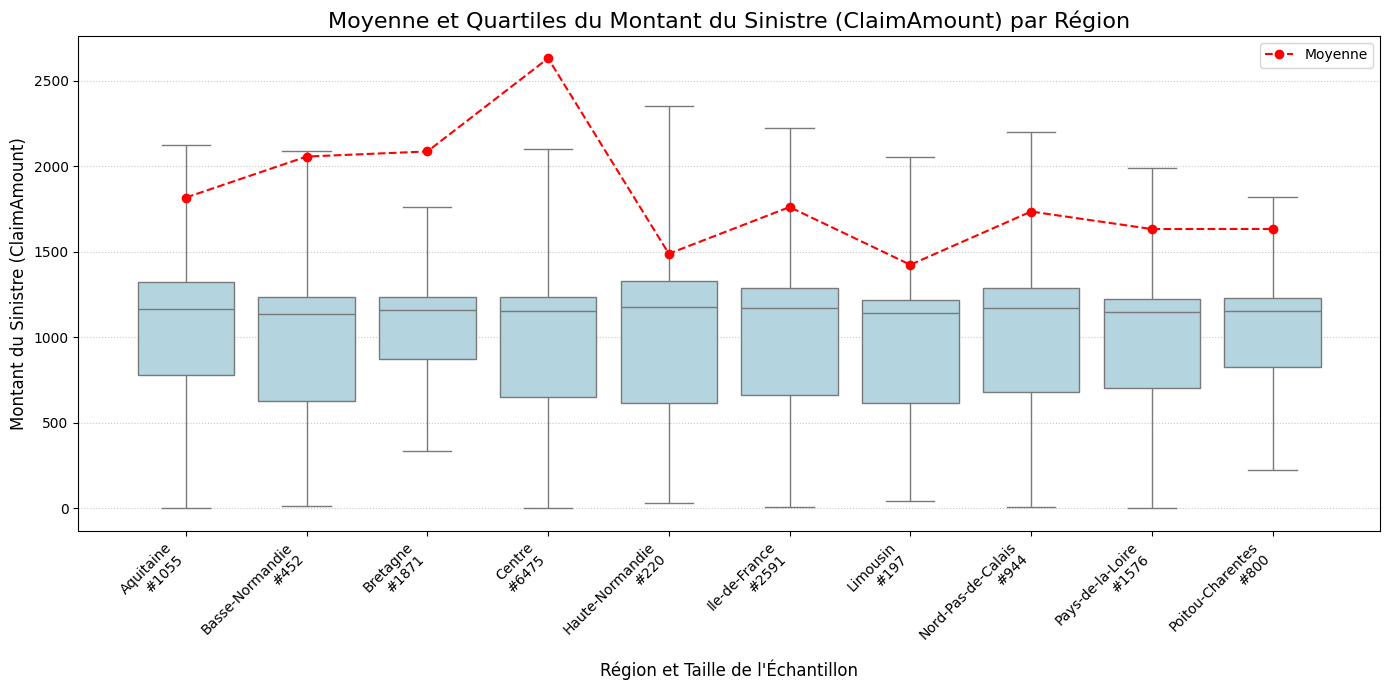

In [64]:
df_clean = df2

region_counts = df_clean.groupby('Region')['ClaimAmount'].count()
regions_to_keep = region_counts[region_counts >= 5].index
df_filtered = df_clean[df_clean['Region'].isin(regions_to_keep)].copy()

mean_claims_filtered = df_filtered.groupby('Region')['ClaimAmount'].mean().reset_index(name='MeanClaim')
final_counts_df = df_filtered.groupby('Region').size().reset_index(name='Count')
plot_stats = pd.merge(mean_claims_filtered, final_counts_df, on='Region')

category_order = plot_stats['Region'].tolist()
plot_stats = plot_stats.set_index('Region').loc[category_order].reset_index()

plt.figure(figsize=(14, 7))

sns.boxplot(
    x='Region',
    y='ClaimAmount',
    data=df_filtered,
    showfliers=False,
    color='lightblue',
    order=category_order
)

plt.plot(
    plot_stats['Region'].astype(str),
    plot_stats['MeanClaim'],
    marker='o',
    linestyle='--',
    color='red',
    label='Moyenne'
)

x_labels = [f"{region}\n#{count}" for region, count in zip(plot_stats['Region'], plot_stats['Count'])]
plt.gca().set_xticklabels(x_labels)

plt.title("Moyenne et Quartiles du Montant du Sinistre (ClaimAmount) par Région", fontsize=16)
plt.xlabel("Région et Taille de l'Échantillon", fontsize=12)
plt.ylabel("Montant du Sinistre (ClaimAmount)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Nous constatons en comparant la moyenne avec les écart-type, que les sinistres extrèmes sont porté par les régions Centre et Bretagne.

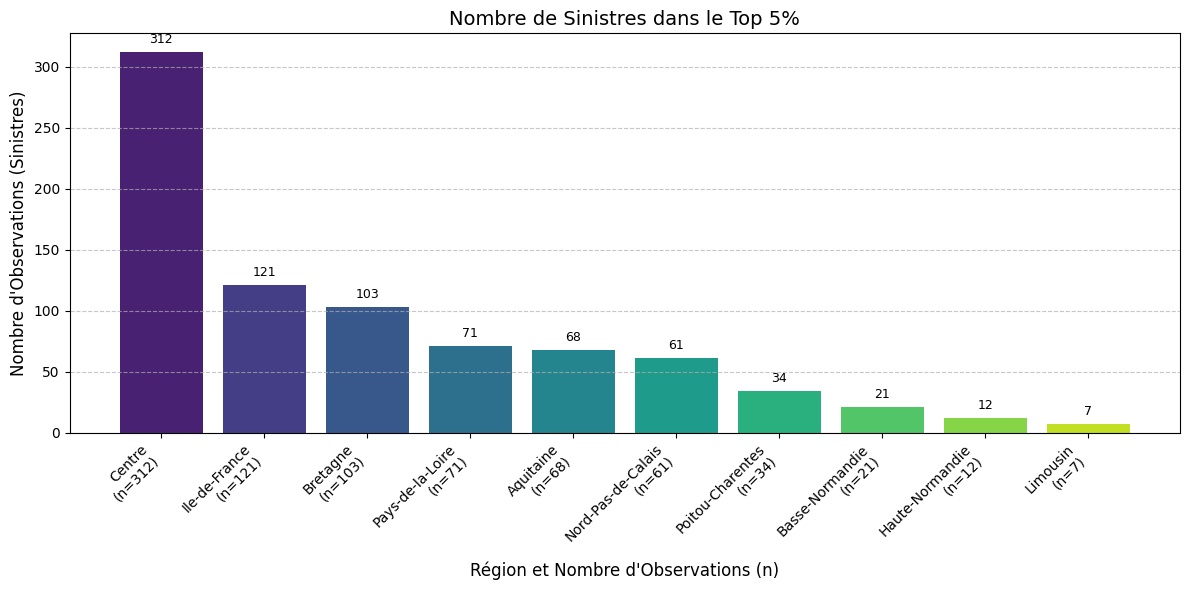

In [65]:
# Calcul du 95e percentile (seuil)
threshold_95 = df2['ClaimAmount'].quantile(0.95)

# Filtrage : Garder uniquement les sinistres supérieurs ou égaux au seuil
df_top_5_percent = df2[df2['ClaimAmount'] >= threshold_95].copy()

counts_by_region = df_top_5_percent.groupby('Region')['ClaimAmount'].count().reset_index(name='Count')
counts_by_region = counts_by_region.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 6))

bars = plt.bar(
    counts_by_region['Region'],
    counts_by_region['Count'],
    color=sns.color_palette("viridis", len(counts_by_region))
)

x_labels = [f"{region}\n(n={count})" for region, count in zip(counts_by_region['Region'], counts_by_region['Count'])]

plt.gca().set_xticks(np.arange(len(x_labels)))
plt.gca().set_xticklabels(x_labels, rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=9)

plt.title(f"Nombre de Sinistres dans le Top 5%", fontsize=14)
plt.xlabel("Région et Nombre d'Observations (n)", fontsize=12)
plt.ylabel("Nombre d'Observations (Sinistres)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipykernel_38314/2354160554.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(x_labels)


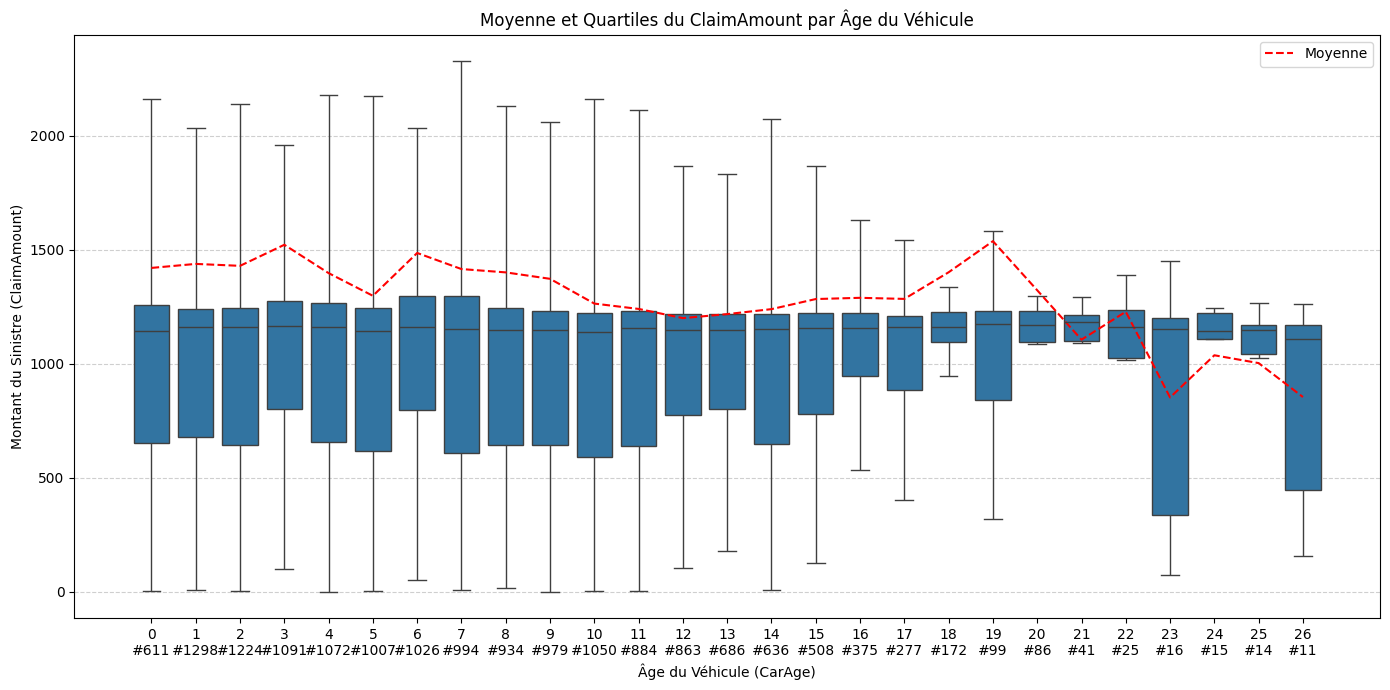

In [66]:
df_clean = df2[df2['ClaimAmount'] < df2['ClaimAmount'].quantile(0.99)].copy()

counts_by_age = df_clean.groupby('CarAge')['ClaimAmount'].count().reset_index(name='Count')
ages_to_keep = counts_by_age[counts_by_age['Count'] >= 5]['CarAge'].tolist()
df_final_filtered = df_clean[df_clean['CarAge'].isin(ages_to_keep)].copy()

mean_claims_filtered = df_final_filtered.groupby('CarAge')['ClaimAmount'].mean().reset_index()
final_counts = df_final_filtered.groupby('CarAge')['ClaimAmount'].count().reset_index(name='Count')

plt.figure(figsize=(14, 7))

sns.boxplot(
    x='CarAge', 
    y='ClaimAmount', 
    data=df_final_filtered, 
    showfliers=False)

plt.plot(
    mean_claims_filtered['CarAge'].astype(str), 
    mean_claims_filtered['ClaimAmount'], 
    linestyle='--',
    color='red',
    label='Moyenne'
)

x_labels = [f"{age}\n#{count}" for age, count in zip(final_counts['CarAge'], final_counts['Count'])]
plt.gca().set_xticklabels(x_labels)

plt.title("Moyenne et Quartiles du ClaimAmount par Âge du Véhicule")
plt.xlabel("Âge du Véhicule (CarAge)")
plt.ylabel("Montant du Sinistre (ClaimAmount)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

On remarque une légère décroissance de la sévérité des sinistre avec l'age de la voiture, bien que le nombre d'observation reste limité sur les ages les plus élevés.

## II.2 GLM 

L'exploration initiale des données de sinistres oriente notre choix vers l'utilisation d'une Loi Gamma ou Gaussienne pour modéliser la séverité des sinitres. Afin d'identifier la combinaison la plus performante, nous testons plusieurs fonctions de lien (comme log, identité, inverse) en association avec chaque loi retenue.

Afin de gérer les valeurs extrêmes de ClaimAmount (les 1% les plus élevés) sans supprimer les lignes entières (initialement réalisé), et de préserver l'information des autres variables associées à ces observations, nous écrêtons le 99e percentile.

La combinaison optimale est sélectionnée sur la base de l'AIC.

In [67]:
seuil_max = df2['ClaimAmount'].quantile(0.99)
df_clean = df2.copy()

# Appliquer l'écrêtage sur la colonne 'ClaimAmount'
df_clean['ClaimAmount'] = np.clip(
    df_clean['ClaimAmount'],
    a_min=0,  
    a_max=seuil_max
)

train_sev = df_clean[df_clean['PolicyID'].isin(train_ids)].copy()
test_sev = df_clean[df_clean['PolicyID'].isin(test_ids)].copy()


In [68]:
formula = "ClaimAmount ~ C(Brand) + C(Gas) + C(Region) + C(Power) + CarAge + DriverAge + Density"
families = {
    'Gaussian (Id)':      sm.families.Gaussian(sm.families.links.Identity()),
    'Gaussian (Log)':     sm.families.Gaussian(sm.families.links.Log()),
    'Gamma (Log)':        sm.families.Gamma(sm.families.links.Log()),
    'Gamma (Canonical)':  sm.families.Gamma(sm.families.links.InversePower()), 
    'InvGauss (Log)':     sm.families.InverseGaussian(sm.families.links.Log())
}

results = []

for name, fam in families.items():
    try:
        m = smf.glm(formula, data=train_sev, family=fam).fit()
        results.append({
            'Distribution': name,
            'AIC': m.aic,

            'BIC': m.bic_llf,
            'Deviance': m.deviance,
            'Model': m  
        })
    except:
        pass 

comparison_df = pd.DataFrame(results).sort_values('AIC').reset_index(drop=True)


print(comparison_df.drop(columns='Model'))

/opt/python/lib/python3.13/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


        Distribution            AIC            BIC      Deviance
0        Gamma (Log)  204331.863472  204561.221436  1.189088e+04
1  Gamma (Canonical)  204349.202734  204578.560698  1.189282e+04
2     InvGauss (Log)  208832.293164  209061.651128  2.515050e+01
3     Gaussian (Log)  218881.898983  219111.256947  5.265346e+10
4      Gaussian (Id)  218882.029528  219111.387492  5.265420e+10


Nous sélectionnons la Loi Gamma avec une fonction de lien logarithmique. Remarquons que la fonction logarithmique nous assure que les prédiction des sévérité demeure positive

In [69]:
cols = ['C(Brand)', 'C(Gas)', 'C(Region)', 'C(Power)', 'CarAge', 'DriverAge', 'Density']

model = smf.glm(f"ClaimAmount ~ {' + '.join(cols)}", data=train_sev, family=sm.families.Gamma(sm.families.links.Log())).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            ClaimAmount   No. Observations:                12072
Model:                            GLM   Df Residuals:                    12041
Model Family:                   Gamma   Df Model:                           30
Link Function:                    Log   Scale:                          1.8660
Method:                          IRLS   Log-Likelihood:            -1.0213e+05
Date:                Thu, 11 Dec 2025   Deviance:                       11891.
Time:                        22:14:50   Pearson chi2:                 2.25e+04
No. Iterations:                    15   Pseudo R-squ. (CS):           0.005349
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          7.4167      0.092     80.829      0.000       7.237       7.597
C(Brand)[T.Japanese (except Nissan) or Korean]     0.1567      0.070      2.227      0.026       0.019       0.295
C(Brand)[T.Mercedes, Chrysler or BMW]              0.0277      0.082      0.335      0.737      -0.134       0.189
C(Brand)[T.Opel, General Motors or Ford]          -0.0534      0.070     -0.762      0.446      -0.191       0.084
C(Brand)[T.Renault, Nissan or Citroen]            -0.0047      0.061     -0.077      0.939      -0.124       0.115
C(Brand)[T.Volkswagen, Audi, Skoda or Seat]        0.0404      0.072      0.559      0.576      -0.101       0.182
C(Brand)[T.other]                                  0.0285      0.098      0.292      0.770      -0.163       0.220
C(Gas)[T.Regular]                                 -0.0049      0.027     -0.180      0.857      -0.058       0.049
C(Region)[T.Basse-Normandie]                      -0.0856      0.091     -0.939      0.348      -0.264       0.093
C(Region)[T.Bretagne]                              0.0225      0.062      0.366      0.714      -0.098       0.143
C(Region)[T.Centre]                               -0.0375      0.054     -0.698      0.485      -0.143       0.068
C(Region)[T.Haute-Normandie]                      -0.0722      0.120     -0.601      0.548      -0.308       0.163
C(Region)[T.Ile-de-France]                        -0.0298      0.064     -0.469      0.639      -0.154       0.095
C(Region)[T.Limousin]                             -0.1711      0.120     -1.428      0.153      -0.406       0.064
C(Region)[T.Nord-Pas-de-Calais]                   -0.0102      0.071     -0.143      0.886      -0.150       0.130
C(Region)[T.Pays-de-la-Loire]                     -0.0598      0.063     -0.942      0.346      -0.184       0.065
C(Region)[T.Poitou-Charentes]                     -0.0189      0.075     -0.252      0.801      -0.166       0.128
C(Power)[T.e]                                      0.0233      0.045      0.523      0.601      -0.064       0.111
C(Power)[T.f]                                      0.0647      0.043      1.492      0.136      -0.020       0.150
C(Power)[T.g]                                      0.0938      0.043      2.175      0.030       0.009       0.178
C(Power)[T.h]                                      0.0141      0.062      0.229      0.819      -0.106       0.135
C(Power)[T.i]                                      0.1396      0.069      2.028      0.043       0.005       0.274
C(Power)[T.j]                                      0.0530      0.069      0.770      0.441      -0.082       0.188
C(Power)[T.k]                                      0.1112      0.089      1.253      0.210   

In [70]:
def extract_non_significant_factors(model, alpha=0.05, factors=['Brand', 'Region']):
    """
    Extrait un dictionnaire des catégories non significatives (P > alpha)
    pour les facteurs C(Brand) et C(Region).
    """
    pvalues = model.pvalues
    non_sig_coefs = pvalues[pvalues > alpha].index
    
    non_sig_categories = {factor: [] for factor in factors}
    
    # Parcourir les coefficients non significatifs
    for coef in non_sig_coefs:
        for factor in factors:
            # Recherche des coefficients de type C(Factor)[T.Label]
            if f'C({factor})' in coef:
                # L'expression régulière est correcte
                match = re.search(r'C\(' + re.escape(factor) + r'\)\[T\.(.*?)\]', coef)
                if match:
                    # Ajout du label à la liste correspondante
                    label = match.group(1).strip().strip('`')
                    non_sig_categories[factor].append(label)
                    
    return non_sig_categories

In [71]:
non_significant = extract_non_significant_factors(model)
non_significant_brands = non_significant.get('Brand', [])
non_significant_regions = non_significant.get('Region', [])

print(f"non_significant_brand = {non_significant_brands}")
print(f"non_significant_region = {non_significant_regions}")

non_significant_brand = ['Mercedes, Chrysler or BMW', 'Opel, General Motors or Ford', 'Renault, Nissan or Citroen', 'Volkswagen, Audi, Skoda or Seat', 'other']
non_significant_region = ['Basse-Normandie', 'Bretagne', 'Centre', 'Haute-Normandie', 'Ile-de-France', 'Limousin', 'Nord-Pas-de-Calais', 'Pays-de-la-Loire', 'Poitou-Charentes']


In [72]:
def apply_aggregation2(df):
    """Applique les règles de regroupement définies au DataFrame."""
    
    # Brand Aggregation
    non_significant_brands.append('Fiat')
    df['Brand_Agg'] = np.where(
        df['Brand'].isin(non_significant_brands),
        'Ref_Brand', 
        df['Brand']
    )

    # Region Aggregation
    non_significant_regions.append('Aquitaine')
    df['Region_Agg'] = np.where(
        df['Region'].isin(non_significant_regions),
        'Ref_Region', 
        df['Region']
    )
    
    # Power Aggregation
    df['Power_Agg'] = np.where(
        df['Power'].isin(non_significant_power),
        'Ref_Power', 
        df['Power']
    )
    return df

train_sev = apply_aggregation2(train_sev.copy())
test_sev = apply_aggregation2(test_sev.copy()) 

In [73]:
cols = ['C(Brand_Agg)','CarAge', 'Density']

model_sign = smf.glm(
    f"ClaimAmount ~ {' + '.join(cols)}", 
    data=train_sev, 
    family=sm.families.Gamma(sm.families.links.Log())
).fit()

model_sign.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            ClaimAmount   No. Observations:                12072
Model:                            GLM   Df Residuals:                    12068
Model Family:                   Gamma   Df Model:                            3
Link Function:                    Log   Scale:                          1.8933
Method:                          IRLS   Log-Likelihood:            -1.0221e+05
Date:                Thu, 11 Dec 2025   Deviance:                       11937.
Time:                        22:14:51   Pearson chi2:                 2.28e+04
No. Iterations:                    11   Pseudo R-squ. (CS):           0.003273
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     7.5290      0.038    197.418      0.000       7.454       7.604
C(Brand_Agg)[T.Ref_Brand]    -0.1538      0.040     -3.821      0.000      -0.233      -0.075
CarAge                       -0.0079      0.003     -3.144      0.002      -0.013      -0.003
Density                   -8.911e-06   2.61e-06     -3.414      0.001    -1.4e-05   -3.79e-06
=============================================================================================
"""

## III. Calcul de la prime


Pour construire la prime pure, on multiplie la fréquence attendue des sinistres par la sévérité moyenne attendue. Cette formule repose sur le fait que l’espérance d’un produit entre le nombre de sinistres N et le coût unitaire S peut s’écrire comme E[N] × E[S].
Cela repose sur l'hypothèse d'indépendance entre N et S.


In [74]:
test['lambda_hat'] = poisson_model.predict(test)
test['mu_hat'] = model_sign.predict(test)

In [75]:
resultat_faibles_claims = test.sort_values(
    by='mu_hat',  
    ascending=True     
).head(10)             

print(resultat_faibles_claims)

        PolicyID  ClaimNb  Exposure Power  CarAge  DriverAge  \
28407      28408        0      0.49     g      99         52   
116468    116469        0      0.67     f     100         36   
116467    116468        0      0.32     f     100         36   
89215      89216        0      0.78     i     100         20   
89214      89215        0      0.21     i     100         20   
105908    105909        0      0.63     f     100         75   
117947    117948        0      0.07     e     100         32   
113617    113618        0      0.63     f     100         52   
97013      97014        0      0.01     g     100         57   
57777      57778        0      0.28     k      99         46   

                             Brand      Gas              Region  Density  \
28407    Mercedes, Chrysler or BMW  Regular       Ile-de-France    27000   
116468  Renault, Nissan or Citroen   Diesel       Ile-de-France     3385   
116467  Renault, Nissan or Citroen   Diesel       Ile-de-France    

In [76]:
real_sev = (
    merged_df
    .groupby('PolicyID')['ClaimAmount']
    .sum()
    .reset_index()
)

test_final = (
    test.groupby('PolicyID')
        .agg({
            'lambda_hat': 'first',
            'mu_hat': 'first',
            'Exposure': 'first',
            'ClaimNb': 'sum',
            'Power': 'first',
            'Brand': 'first',
            'Region': 'first',
            'CarAge': 'first',
            'DriverAge': 'first',   
        })
        .reset_index()
)

test_final = test_final.merge(real_sev, on='PolicyID', how='left')
test_final['ClaimAmount'] = test_final['ClaimAmount'].fillna(0)

In [77]:
test_final['ClaimNb_hat'] = (
    test_final['lambda_hat'] *
    test_final['Exposure']
)

test_final['prime_hat'] = (
    test_final['lambda_hat'] *
    test_final['mu_hat'] *
    test_final['Exposure']
)




In [78]:
# Loss ratio global
loss_ratio = test_final['ClaimAmount'].sum() / test_final['prime_hat'].sum()
print("Loss Ratio global:", loss_ratio)

Loss Ratio global: 1.2842085464644817


In [79]:
summary = test_final[['ClaimNb_hat','ClaimNb','ClaimAmount', 'prime_hat']].sum()
print(summary)

ClaimNb_hat    4.032477e+03
ClaimNb        4.109000e+03
ClaimAmount    7.816155e+06
prime_hat      6.086360e+06
dtype: float64


In [80]:
resultat_faibles_claims = test_final.sort_values(
    by='prime_hat',  
    ascending=True     
).head(10)             

print(resultat_faibles_claims)

       PolicyID  lambda_hat       mu_hat  Exposure  ClaimNb Power  \
7824      31577    0.037920  1351.676746  0.002732        0     d   
24328     97014    0.020035   723.689065  0.010000        0     g   
63287    252728    0.041365  1401.281872  0.002740        0     d   
66493    265624    0.041030  1416.635659  0.002740        0     d   
89057    356562    0.044239  1330.242067  0.002732        0     h   
47208    188964    0.046486  1369.470231  0.002740        0     g   
92786    371371    0.045193  1439.680500  0.002732        0     g   
8362      33766    0.051256  1286.769309  0.002732        0     g   
7730      31195    0.044434  1495.404039  0.002732        0     d   
44349    177287    0.045929  1462.891636  0.002740        0     d   

                            Brand            Region  CarAge  DriverAge  \
7824   Renault, Nissan or Citroen            Centre      21         67   
24328  Renault, Nissan or Citroen          Bretagne     100         57   
63287  Renault, Ni

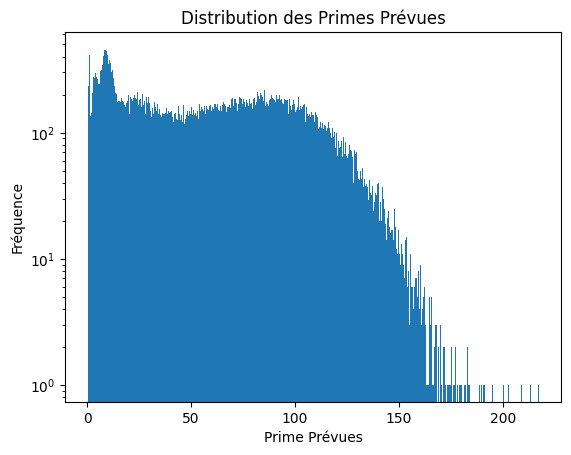

In [81]:
plt.hist(test_final['prime_hat'], bins=1000)
plt.title("Distribution des Primes Prévues")
plt.xlabel("Prime Prévues")
plt.ylabel("Fréquence")
plt.yscale('log')  
plt.show()

In [82]:
# 0) variables utiles
total_claims = test_final['ClaimAmount'].sum()
total_primes = test_final['prime_hat'].sum()

# 1) LR sans les 1% les plus chers
cap = test_final['ClaimAmount'].quantile(0.999)
df_rest = test_final[test_final['ClaimAmount'] <= cap]
loss_ratio_rest = df_rest['ClaimAmount'].sum() / df_rest['prime_hat'].sum()

# 2) LR des 1% supérieurs (top)
df_top = test_final[test_final['ClaimAmount'] > cap]
loss_ratio_top = df_top['ClaimAmount'].sum() / df_top['prime_hat'].sum()

# 3) Contribution des top 1% aux montants et aux primes
share_claims_top = df_top['ClaimAmount'].sum() / total_claims
share_primes_top = df_top['prime_hat'].sum() / total_primes
coverage_top = df_top['prime_hat'].sum() / df_top['ClaimAmount'].sum()  # prime / sinistres pour le top

print("Total claims / primes:", total_claims, total_primes)
print("Cap (99.9%) :", cap)
print("LR overall:", total_claims / total_primes)
print("LR without top 0.1%:", loss_ratio_rest)
print("LR top 0.1%:", loss_ratio_top)
print("Share of claims from top 0.1%:", share_claims_top)
print("Share of primes from top 0.1%:", share_primes_top)
print("Prime coverage for top 0.1% (prime/sinistre):", coverage_top)


Total claims / primes: 7816155.0 6086359.588182492
Cap (99.9%) : 7700.496000000159
LR overall: 1.2842085464644817
LR without top 0.1%: 0.7902885767680904
LR top 0.1%: 488.1770016216767
Share of claims from top 0.1%: 0.385234044104806
Share of primes from top 0.1%: 0.0010134046671290376
Prime coverage for top 0.1% (prime/sinistre): 0.0020484373427631718


L'analyse du portefeuille montre que le Loss Ratio global est de **1,42**, ce qui signifie que les primes calculées couvrent moins que la totalité des sinistres : le modèle sous-tarife donc l’ensemble du portefeuille.  

En examinant les sinistres extrêmes, on voit que sur le jeu de test les 0,1% des sinistres les plus élevés représentent ≈38,5% du montant total des sinistres, alors qu’ils ne génèrent que 0,1% des primes.    

En retirant ce top 0,1%, le Loss Ratio sur le reste du portefeuille tombe à 0,87, montrant que le modèle couvre correctement la majorité des petits et moyens sinistres.  

Conclusion : le modèle fréquence × sévérité capture bien la masse des sinistres ordinaires mais sous-tarife fortement les sinistres extrêmes. Pour améliorer la tarification, il serait pertinent d’envisager un traitement spécifique des queues.


## IV. Entraînement du modèle sur toutes les données

On considère les modèles validés dans la partie précédente, et on entraîne toute notre base de données avec.

In [83]:
freMTPLfreq = apply_aggregation(freMTPLfreq.copy())
freMTPLfreq['log_exposure'] = np.log(freMTPLfreq['Exposure'])


# Formule finale avec les variables agrégées (simplifiées)
final_formula = "ClaimNb ~ CarAge + DriverAge + C(Brand_Agg) + C(Gas) + C(Region_Agg) + Density + C(Power_Agg)"

# Modèle Poisson 
global_poisson_model = smf.glm(
    formula=final_formula,
    data=freMTPLfreq,
    family=Poisson(),
    offset=freMTPLfreq['log_exposure']
).fit()


# Prédictions de Taux de Fréquence (lambda hat) sur le jeu de TEST
freMTPLfreq['poisson_rate'] = global_poisson_model.predict(freMTPLfreq)

In [84]:
merged_df = apply_aggregation2(merged_df.copy())

# Ne garder que les sinistres > 0
merged_df_sev = merged_df[merged_df['ClaimAmount'] > 0].copy()
merged_df_sev = merged_df_sev[merged_df_sev['ClaimAmount'] < merged_df_sev['ClaimAmount'].quantile(0.999)].copy()

cols = ['C(Brand_Agg)','CarAge','Density']

global_model_sign = smf.glm(
    f"ClaimAmount ~ {' + '.join(cols)}",
    data=merged_df_sev,
    family=sm.families.Gamma(sm.families.links.Log())
).fit()

# Prédictions sur toutes les lignes (même celles avec ClaimAmount=0)
merged_df['gamma_rate'] = global_model_sign.predict(merged_df)

In [85]:
agg_sev = merged_df.groupby('PolicyID').agg({
    'ClaimAmount': 'sum',   # total sinistres par policy
    'gamma_rate': 'mean'    # prédiction moyenne par sinistre, ou 'first' si toutes identiques
}).reset_index()

In [86]:
df_final = freMTPLfreq.merge(agg_sev, on='PolicyID', how='left')
df_final['ClaimAmount'] = df_final['ClaimAmount'].fillna(0)

In [87]:
df_final["prime"] = df_final["poisson_rate"] * df_final["gamma_rate"] * df_final["Exposure"]

In [88]:
# Loss Ratio global
loss_ratio = df_final['ClaimAmount'].sum() / df_final['prime'].sum()
print("Loss Ratio global:", loss_ratio)

Loss Ratio global: 1.2357042269367178


## V. Modèle pénalisé

On entraîne ici des MLG avec pénalisation Lasso, afin de comparer les résultats avec la partie précédente. Le coefficient de pénalisation est choisi par une Cross-validation suivant la méthologie du k-fold. On entraîne deux modèles avec pénalisation différents pour la fréquence et la sévérité, puis on calcule la prime comme précédemment. 


In [89]:
import patsy
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Variables explicatives
cols = ['CarAge', 'DriverAge', 'C(Brand_Agg)', 'C(Gas)', 'C(Region_Agg)', 'Density', 'C(Power_Agg)']

# Construire matrice X / y avec patsy
y, X = patsy.dmatrices("ClaimNb ~ " + " + ".join(cols), data=freMTPLfreq, return_type='dataframe')
offset = np.log(freMTPLfreq['Exposure'].values)

# --- Normalisation des variables numériques ---
num_cols = ['CarAge', 'DriverAge', 'Density']

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Grille de pénalisation
alphas = [0.005, 0.01]

kf = KFold(n_splits=4, shuffle=True, random_state=42)
best_alpha = None
best_score = np.inf

# Cross-validation
for alpha in alphas:
    cv_scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        offset_train, offset_test = offset[train_idx], offset[test_idx]

        model = sm.GLM(y_train, X_train, family=sm.families.Poisson(), offset=offset_train)
        result = model.fit_regularized(alpha=alpha, L1_wt=1.0)

        y_pred = result.predict(X_test, offset=offset_test)

        exposure_test = freMTPLfreq['Exposure'].iloc[test_idx]

        weighted_mae = np.sum(exposure_test * np.abs(y_test.values.flatten() - y_pred)) \
                        / np.sum(exposure_test)

        cv_scores.append(weighted_mae)

    mean_score = np.mean(cv_scores)

    if mean_score < best_score:
        best_score = mean_score
        best_alpha = alpha

print("Meilleur alpha choisi:", best_alpha)

Meilleur alpha choisi: 0.005


In [90]:
#  Modèle final pour la fréquence 
final_model = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset).fit_regularized(alpha=best_alpha, L1_wt=1.0)

freMTPLfreq['lambda_hat_pen'] = final_model.predict(X, offset=offset) 

In [91]:
final_model.params

Intercept                   -2.537552
C(Brand_Agg)[T.Ref_Brand]    0.000000
C(Gas)[T.Regular]            0.000000
C(Power_Agg)[T.d]            0.000000
CarAge                       0.000000
DriverAge                   -0.041704
Density                      0.000000
dtype: float64

In [92]:
merged_df_sev = merged_df[merged_df['ClaimAmount'] > 0].copy()
#merged_df_sev = merged_df_sev[merged_df_sev['ClaimAmount'] < merged_df_sev['ClaimAmount'].quantile(0.999)].copy()


# Construire X et y sur le sous-échantillon des sinistres
y_sev, X_sev = patsy.dmatrices(
    "ClaimAmount ~ " + " + ".join(cols), 
    data=merged_df_sev, 
    return_type='dataframe'
)

scaler = StandardScaler()
X_sev[num_cols] = scaler.fit_transform(X_sev[num_cols])

# Grille L1
alphas = [0.01, 0.1]

kf = KFold(n_splits=4, shuffle=True, random_state=42)
best_alpha = None
best_score = np.inf

for alpha in alphas:
    cv_scores = []
    for train_idx, test_idx in kf.split(X_sev):
        
        X_train, X_test = X_sev.iloc[train_idx], X_sev.iloc[test_idx]
        y_train, y_test = y_sev.iloc[train_idx], y_sev.iloc[test_idx]

        model = sm.GLM(
            y_train, X_train,
            family=sm.families.Gamma(sm.families.links.Log())
        )

        result = model.fit_regularized(alpha=alpha, L1_wt=1.0)

        y_pred = result.predict(X_test)

        # MAE sur sinistres
        mae = np.mean(abs(y_test.values.flatten() - y_pred))
        cv_scores.append(mae)

    mean_score = np.mean(cv_scores)

    if mean_score < best_score:
        best_score = mean_score
        best_alpha = alpha

print("Meilleur alpha (sévérité):", best_alpha)

/opt/python/lib/python3.13/site-packages/statsmodels/genmod/generalized_linear_model.py:1464: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")


Meilleur alpha (sévérité): 0.1


In [93]:
result.params

Intercept                    7.536863
C(Brand_Agg)[T.Ref_Brand]    0.000000
C(Gas)[T.Regular]            0.000000
C(Power_Agg)[T.d]            0.000000
CarAge                       0.000000
DriverAge                    0.000000
Density                      0.000000
dtype: float64

In [94]:
final_model_sev = sm.GLM(y_sev, X_sev, family=sm.families.Gamma(sm.families.links.Log())).fit_regularized(alpha=best_alpha, L1_wt=1.0)

_, X_all = patsy.dmatrices("ClaimAmount ~ " + " + ".join(cols), data=merged_df, return_type='dataframe')
X_all[num_cols] = scaler.transform(X_all[num_cols])

merged_df['mu_hat_pen'] = final_model_sev.predict(X_all)

In [95]:
agg_sev_pen = merged_df.groupby('PolicyID').agg({
    'ClaimAmount': 'sum',   # total sinistres par policy
    'mu_hat_pen': 'mean'    # prédiction moyenne par sinistre, ou 'first' si toutes identiques
}).reset_index()

In [96]:
df_pen = freMTPLfreq.merge(agg_sev_pen, on='PolicyID', how='left')
df_pen['ClaimAmount'] = df_final['ClaimAmount'].fillna(0)

In [97]:
df_pen["prime_pen"] = df_pen["lambda_hat_pen"] * df_pen["mu_hat_pen"] * df_pen["Exposure"]

In [98]:
# Loss Ratio global
loss_ratio = df_pen['ClaimAmount'].sum() / df_pen['prime_pen'].sum()
print("Loss Ratio global:", loss_ratio)

Loss Ratio global: 1.2157329825233734
